reference:
https://github.com/MPieter/YOLOv4-CoreML-Converter/blob/master/convert.py

In [1]:
import argparse
import configparser
import io
import os
from collections import defaultdict

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                                     UpSampling2D, MaxPooling2D, Concatenate)
from tensorflow.keras.layers import LeakyReLU, Layer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot

import coremltools as ct

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

Using TensorFlow backend.


TensorFlow version is: 2.2.0
Eager execution is: True
Keras version is: 2.3.0-tf


In [2]:
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
config_path = "yolov4-tiny.cfg"
weights_path = "yolov4-tiny.weights"
keras_output_path = 'yolov4_keras_mpieter_23rdMay.h5'
# yolov2-coco-9.mlmodel
output_path  = "yolov4_tiny_keras_mpieter_coreml_23rdMay.mlmodel"

In [5]:
# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
major, minor, revision = np.ndarray(
    shape=(3, ), dtype='int32', buffer=weights_file.read(12))
if (major*10+minor) >= 2 and major < 1000 and minor < 1000:
    seen = np.ndarray(shape=(1,), dtype='int64',
                      buffer=weights_file.read(8))
else:
    seen = np.ndarray(shape=(1,), dtype='int32',
                      buffer=weights_file.read(4))
print('Weights Header: ', major, minor, revision, seen)


Loading weights.
Weights Header:  0 2 5 [0]


In [6]:
def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

In [7]:
print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

Parsing Darknet config.


In [8]:
input_layer = Input(shape=(608, 608, 3))
prev_layer = input_layer
all_layers = []

In [9]:
weight_decay = float(cfg_parser['net_0']['decay']) if 'net_0' in cfg_parser.sections() else 5e-4
weight_decay

0.0005

In [10]:
count = 0
out_index = []

In [11]:
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        batch_normalize = 'batch_normalize' in cfg_parser[section]

        padding = 'same' if pad == 1 and stride == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

        print('conv2d', 'bn'
              if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(
            shape=(filters, ),
            dtype='float32',
            buffer=weights_file.read(filters * 4))
        count += filters

        if batch_normalize:
            bn_weights = np.ndarray(
                shape=(3, filters),
                dtype='float32',
                buffer=weights_file.read(filters * 12))
            count += 3 * filters

            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize else [
            conv_weights, conv_bias
        ]

        # Handle activation.
        act_fn = None
        if activation == 'leaky' or activation == 'mish':
            pass  # Add advanced activation later.
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        if stride > 1:
            # Darknet uses left and top padding instead of 'same' mode
            prev_layer = ZeroPadding2D(((1, 0), (1, 0)))(prev_layer)
        conv_layer = (Conv2D(
            filters, (size, size),
            strides=(stride, stride),
            kernel_regularizer=l2(weight_decay),
            use_bias=not batch_normalize,
            weights=conv_weights,
            activation=act_fn,
            padding=padding))(prev_layer)

        if batch_normalize:
            conv_layer = (BatchNormalization(
                weights=bn_weight_list))(conv_layer)
        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)
        elif activation == 'mish':
            act_layer = Mish()(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('route'):
        ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
        layers = [all_layers[i] for i in ids]
        if len(layers) > 1:
            print('Concatenating route layers:', layers)
            concatenate_layer = Concatenate()(layers)
            all_layers.append(concatenate_layer)
            prev_layer = concatenate_layer
        else:
            skip_layer = layers[0]  # only one layer to route
            all_layers.append(skip_layer)
            prev_layer = skip_layer

    elif section.startswith('maxpool'):
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(
            MaxPooling2D(
                pool_size=(size, size),
                strides=(stride, stride),
                padding='same')(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('shortcut'):
        index = int(cfg_parser[section]['from'])
        activation = cfg_parser[section]['activation']
        assert activation == 'linear', 'Only linear activation supported.'
        all_layers.append(Add()([all_layers[index], prev_layer]))
        prev_layer = all_layers[-1]

    elif section.startswith('upsample'):
        stride = int(cfg_parser[section]['stride'])
        assert stride == 2, 'Only stride=2 supported.'
        all_layers.append(UpSampling2D(stride)(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('yolo'):
        out_index.append(len(all_layers)-1)
        all_layers.append(None)
        prev_layer = all_layers[-1]

    elif section.startswith('net'):
        pass

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (3, 3, 64, 64)
Parsing section route_0
Parsing section convolutional_3
conv2d bn leaky (3, 3, 64, 32)
Parsing section convolutional_4
conv2d bn leaky (3, 3, 32, 32)
Parsing section route_1
Concatenating route layers: [<tf.Tensor 'leaky_re_lu_4/Identity:0' shape=(None, 152, 152, 32) dtype=float32>, <tf.Tensor 'leaky_re_lu_3/Identity:0' shape=(None, 152, 152, 32) dtype=float32>]
Parsing section convolutional_5
conv2d bn leaky (1, 1, 64, 64)
Parsing section route_2
Concatenating route layers: [<tf.Tensor 'leaky_re_lu_2/Identity:0' shape=(None, 152, 152, 64) dtype=float32>, <tf.Tensor 'leaky_re_lu_5/Identity:0' shape=(None, 152, 152, 64) dtype=float32>]
Parsing section maxpool_0
Parsing section convolutional_6
conv2d bn leaky (3, 3, 128, 128)
Parsing section route_3
Parsing section convolutional_7


TypeError: buffer is too small for requested array

In [1]:
# Create and save model.
if len(out_index) == 0:
    out_index.append(len(all_layers)-1)
model = Model(inputs=input_layer, outputs=[
              all_layers[i] for i in out_index])
input_name = model.input_names[0]
print(model.summary())

NameError: name 'out_index' is not defined

In [ ]:
 model.save('{}'.format(keras_output_path))

In [ ]:
model.inputs

In [ ]:
model.outputs

# test keras model

# convert to core ml and test

In [ ]:
coreml_model = ct.convert(model, inputs=[ct.ImageType(scale=1 / 255.0)])

In [ ]:
coreml_model.save(output_path)
print('Saved CoreML model to {}'.format(output_path))

In [ ]:
print(coreml_model)

In [ ]:
print("\nLayers in the converted model:")
for i, layer in enumerate(coreml_model._spec.neuralNetwork.layers):
    if layer.HasField("custom"):
        print("****** Layer %d = %s --> custom layer = %s" %
              (i, layer.name, layer.custom.className))
    else:
        print("Layer %d = %s" % (i, layer.name))

# test keras model inference

In [6]:
from tensorflow.keras.models import load_model, Model
yolo_model = load_model(keras_output_path, custom_objects={"Mish" : Mish()})

# # /yolov4-608
# yolo_model = load_model('yolov4-608')

# from keras.models import load_model, Model
# yolo_model = load_model("yolov4.h5")

In [7]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 mish_7 (Mish)                  (None, 304, 304, 64  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 305, 305, 64  0          ['mish_7[0][0]']                 
 D)                             )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 152, 152, 12  73728       ['zero_padding2d_1[0][0]']       
                                8)                                                                
                                                                                                  
 batch_nor

                                )                                                                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 152, 152, 12  0           ['mish_15[0][0]',                
                                8)                                'mish_9[0][0]']                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 152, 152, 12  16384       ['concatenate_1[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 152, 152, 12  512        ['conv2d_16[0][0]']              
 ormalization)                  8)                                                                
          

                                                                                                  
 batch_normalization_26 (BatchN  (None, 76, 76, 128)  512        ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 mish_26 (Mish)                 (None, 76, 76, 128)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 76, 76, 128)  147456      ['mish_26[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 76, 76, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_36 (Conv2D)             (None, 76, 76, 128)  16384       ['add_10[0][0]']                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 76, 76, 128)  32768       ['mish_17[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 76, 76, 128)  512        ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_18 (BatchN  (None, 76, 76, 128)  512        ['conv2d_18[0][0]']              
 ormalization)                                                                                    
          

 conv2d_46 (Conv2D)             (None, 38, 38, 256)  589824      ['mish_45[0][0]']                
                                                                                                  
 batch_normalization_46 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 mish_46 (Mish)                 (None, 38, 38, 256)  0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 add_13 (Add)                   (None, 38, 38, 256)  0           ['add_12[0][0]',                 
                                                                  'mish_46[0][0]']                
                                                                                                  
 conv2d_47

 mish_55 (Mish)                 (None, 38, 38, 256)  0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 38, 38, 256)  589824      ['mish_55[0][0]']                
                                                                                                  
 batch_normalization_56 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 mish_56 (Mish)                 (None, 38, 38, 256)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 add_18 (Add)                   (None, 38, 38, 256)  0           ['add_17[0][0]',                 
          

                                                                                                  
 mish_65 (Mish)                 (None, 19, 19, 512)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 add_20 (Add)                   (None, 19, 19, 512)  0           ['add_19[0][0]',                 
                                                                  'mish_65[0][0]']                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 19, 19, 512)  262144      ['add_20[0][0]']                 
                                                                                                  
 batch_normalization_66 (BatchN  (None, 19, 19, 512)  2048       ['conv2d_66[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_74 (BatchN  (None, 19, 19, 512)  2048       ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 19, 19, 512)  0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 19, 19, 512)  0          ['leaky_re_lu_2[0][0]']          
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 19, 19, 512)  0          ['leaky_re_lu_2[0][0]']          
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_11 (LeakyReLU)     (None, 38, 38, 512)  0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 38, 38, 256)  131072      ['leaky_re_lu_11[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 38, 38, 256)  0           ['batch_normalization_84[0][0]'] 
          

 leaky_re_lu_22 (LeakyReLU)     (None, 38, 38, 256)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 38, 38, 512)  1179648     ['leaky_re_lu_22[0][0]']         
                                                                                                  
 batch_normalization_95 (BatchN  (None, 38, 38, 512)  2048       ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_23 (LeakyReLU)     (None, 38, 38, 512)  0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 38, 38, 256)  131072      ['leaky_re_lu_23[0][0]']         
          

                                                                                                  
 conv2d_100 (Conv2D)            (None, 38, 38, 512)  1179648     ['leaky_re_lu_26[0][0]']         
                                                                                                  
 conv2d_108 (Conv2D)            (None, 19, 19, 1024  4718592     ['leaky_re_lu_33[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_92 (BatchN  (None, 76, 76, 256)  1024       ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_99 (BatchN  (None, 38, 38, 512)  2048       ['conv2d_100[0][0]']             
 ormalizat

In [8]:
yolo_model.inputs

[<KerasTensor: shape=(None, 608, 608, 3) dtype=float32 (created by layer 'input_1')>]

In [9]:
yolo_model.outputs

[<KerasTensor: shape=(None, 76, 76, 255) dtype=float32 (created by layer 'conv2d_93')>,
 <KerasTensor: shape=(None, 38, 38, 255) dtype=float32 (created by layer 'conv2d_101')>,
 <KerasTensor: shape=(None, 19, 19, 255) dtype=float32 (created by layer 'conv2d_109')>]

In [10]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [11]:
# reference https://github.com/AlexeyAB/darknet/blob/master/cfg/coco.names
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [12]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height


In [37]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = 'joshua_newnham_4.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  800 600
input image (1, 608, 608, 3)


In [38]:
# Run the model
yhat = yolo_model.predict(image)
print("output:",[a.shape for a in yhat])

output: [(1, 76, 76, 255), (1, 38, 38, 255), (1, 19, 19, 255)]


In [39]:
# Draw bounding boxes
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, anchors_nb, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    nb_box = anchors_nb
    print(f'netout before reshape {netout.shape}')
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    print(f'netout after reshape {netout.shape}')
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc
    
    print(f'nb_class shape {nb_class}')
    print("grid_h,grid_w: ",grid_h,grid_w)   
       
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y #- 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and hhttp://localhost:8889/notebooks/Documents/code/iOS/learn/CVRecorder/converters/YoloToCoreML%20Converter.ipynb#
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes

In [40]:
# Compute the Yolo layers
obj_thresh = 0.45
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    print(f'<<<<<<<<<<<<<<<< start decoding for achor set {i} >>>>>>>>>>>>>>>>>>>>>')
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, len(anchors), scales_x_y[i])
    print(f'<<<<<<<<<<<<<<<< end decoding for achor set {i} >>>>>>>>>>>>>>>>>>>>>')

print("nb boxes detected; ",len(boxes))

<<<<<<<<<<<<<<<< start decoding for achor set 0 >>>>>>>>>>>>>>>>>>>>>
netout before reshape (76, 76, 255)
netout after reshape (76, 76, 3, 85)
nb_class shape 80
grid_h,grid_w:  76 76
<<<<<<<<<<<<<<<< end decoding for achor set 0 >>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<< start decoding for achor set 1 >>>>>>>>>>>>>>>>>>>>>
netout before reshape (38, 38, 255)
netout after reshape (38, 38, 3, 85)
nb_class shape 80
grid_h,grid_w:  38 38
<<<<<<<<<<<<<<<< end decoding for achor set 1 >>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<< start decoding for achor set 2 >>>>>>>>>>>>>>>>>>>>>
netout before reshape (19, 19, 255)
netout after reshape (19, 19, 3, 85)
nb_class shape 80
grid_h,grid_w:  19 19
objectness:  0.4784394
objectness:  0.4904975
objectness:  0.4843796
objectness:  0.4814004
objectness:  0.71718085
objectness:  0.72789836
objectness:  0.7109225
objectness:  0.6904523
objectness:  0.851354
objectness:  0.8578555
objectness:  0.7137533
objectness:  0.7201964
objectness:  0.8393443
objectness:  0.

In [41]:
# Correct the boxes according the inital size of the image
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [42]:
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [43]:
# Suppress the non Maximal boxes
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [44]:
do_nms(boxes, 0.5)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  30


In [45]:
# Generate colors in bounding boxes
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [46]:
# Get the details of the detected objects for a threshold > 0.25
class_threshold = 0.25
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  7


In [47]:
# Draw the result
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

person 49.037954211235046 448 607 19 285
person 48.427215218544006 0 322 36 373
person 72.73847460746765 535 799 68 588
person 85.76326370239258 -4 251 141 615
person 89.35206532478333 192 380 200 616
person 88.69020342826843 452 798 298 621
person 76.07650756835938 282 523 344 611


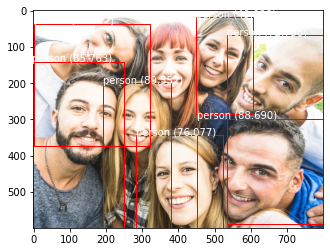

In [48]:
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)

# load and test core ml model

In [ ]:
loaded_coreml_model = ct.models.MLModel(output_path)

In [ ]:
print(loaded_coreml_model)